# Introduction to NeuralHydrology

There are two different ways to use the Python package NeuralHydrology:

1. From the terminal, making use of some high-level entry points (such as `nh-run` and `nh-schedule-runs`)
2. From any other Python file or Jupyter Notebook, using NeuralHydrology's API

For every run that you start, a new folder will be created. This folder is used to store the model and optimizer checkpoints, train data means/stds (needed for scaling during inference), tensorboard log file (can be used to monitor and compare training runs visually), validation results (optionally) and training progress figures (optionally, e.g., model predictions and observations for _n_ random basins). During inference, the evaluation results will also be stored in this directory (e.g., test period results).


### TensorBoard logging
By default, the training progress is logged in TensorBoard files (add `log_tensorboard: False` to the config to disable TensorBoard logging).

To start the TensorBoard dashboard, run:

```
tensorboard --logdir /path/to/run-dir
```

You can also visualize multiple runs at once if you point the `--logdir` to the parent directory (useful for model intercomparison)

## Using NeuralHydrology from the Terminal

### nh-run


Given a run configuration file, you can use the bash command `nh-run` to train/evaluate a model. To train a model, use


```bash
nh-run train --config-file path/to/config.yml
```

to evaluate the model after training, use

```bash
nh-run evaluate --run-dir path/to/run-directory
```

### nh-schedule-runs

If you want to train/evaluate multiple models on different GPUs, you can use the `nh-schedule-runs` command. This tool automatically distributes runs across GPUs and starts a new one, whenever one run finishes.

Calling `nh-schedule-runs` in `train` mode will train one model for each `.yml` file in a directory (or its sub-directories).

```bash
nh-schedule-runs train --directory /path/to/config-dir --runs-per-gpu 2 --gpu_ids 0 1 2 3 
```
Use `-runs-per-gpu` to define the number of models that are simultaneously trained on a _single_ GPU (2 in this case) and `--gpu-ids` to define which GPUs will be used (numbers are ids according to nvidia-smi). In this example, 8 models will train simultaneously on 4 different GPUs.

Calling `nh-schedule-runs` in `evaluate` mode will evaluate all models in all run directories in a given root directory.

```bash
nh-schedule-runs evaluate --directory /path/to/parent-run-dir/ --runs-per-gpu 2 --gpu_ids 0 1 2 3 
```

## Links
A full list of config arguments is listed in the [documentation](https://neuralhydrology.readthedocs.io/en/latest/usage/config.html)

Look at the [API Documentation](https://neuralhydrology.readthedocs.io/en/latest/api/neuralhydrology.html) for a full list of functions/classes you could use.

In [11]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [12]:
all_runs_dir = '/global/home/users/ann_scheliga/neuralhydrology/runs/'
synth_data_dir = '/global/scratch/users/ann_scheliga/CYGNSS_daily/time_series/'

### Train a model for a single config file

In [21]:
start_run(config_file=Path("custom_dataset_trial.yml"), gpu=-1)

2025-04-21 22:23:14,025: Logging to /global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313/output.log initialized.
2025-04-21 22:23:14,029: ### Folder structure created at /global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313
2025-04-21 22:23:14,029: ### Run configurations for notebook_two_var_only
2025-04-21 22:23:14,030: experiment_name: notebook_two_var_only
2025-04-21 22:23:14,031: run_dir: /global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313
2025-04-21 22:23:14,032: train_basin_file: /global/home/users/ann_scheliga/neuralhydrology/cygnss_models/adding_data/1_basin.txt
2025-04-21 22:23:14,032: validation_basin_file: /global/home/users/ann_scheliga/neuralhydrology/cygnss_models/adding_data/1_basin.txt
2025-04-21 22:23:14,033: test_basin_file: /global/home/users/ann_scheliga/neuralhydrology/cygnss_models/adding_data/1_basin.txt
2025-04-21 22:23:14,034: train_start_date: 1999-10-01 00:00

### Evaluate run on test set
Change the `run_dir` argument by grabbing from:
1. above training output log
2. below list of runs

In [22]:
! ls /global/home/users/ann_scheliga/neuralhydrology/runs/

change_to_ealstm_0404_160538	   run_via_notebook_1804_165949
change_to_ealstm_0404_161712	   run_via_notebook_2104_221236
change_to_ealstm_0404_162803	   test_change_exp_name_0204_165321
notebook_two_var_only_2104_222313


In [26]:
run_dir = Path(all_runs_dir,"notebook_two_var_only_2104_222313")
print(run_dir)
eval_run(run_dir=run_dir, period="test")

/global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313
2025-04-21 22:25:29,280: Using the model weights from /global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313/model_epoch050.pt
# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]
2025-04-21 22:25:30,402: Stored metrics at /global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313/test/model_epoch050/test_metrics.csv
2025-04-21 22:25:30,503: Stored results at /global/home/users/ann_scheliga/neuralhydrology/runs/notebook_two_var_only_2104_222313/test/model_epoch050/test_results.p


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [27]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01022500'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [28]:
results['01022500']['1D']['xr']

<xarray.Dataset> Size: 58kB
Dimensions:         (date: 3652, time_step: 1)
Coordinates:
  * date            (date) datetime64[ns] 29kB 1989-10-01 ... 1999-09-30
  * time_step       (time_step) int64 8B 0
Data variables:
    QObs(mm/d)_obs  (date, time_step) float32 15kB 0.6203 0.5537 ... 0.9992
    QObs(mm/d)_sim  (date, time_step) float32 15kB 1.673 1.586 ... 2.824 2.421

Let's plot the model predictions vs. the observations

Text(0.5, 1.0, 'Test period - NSE -0.057')

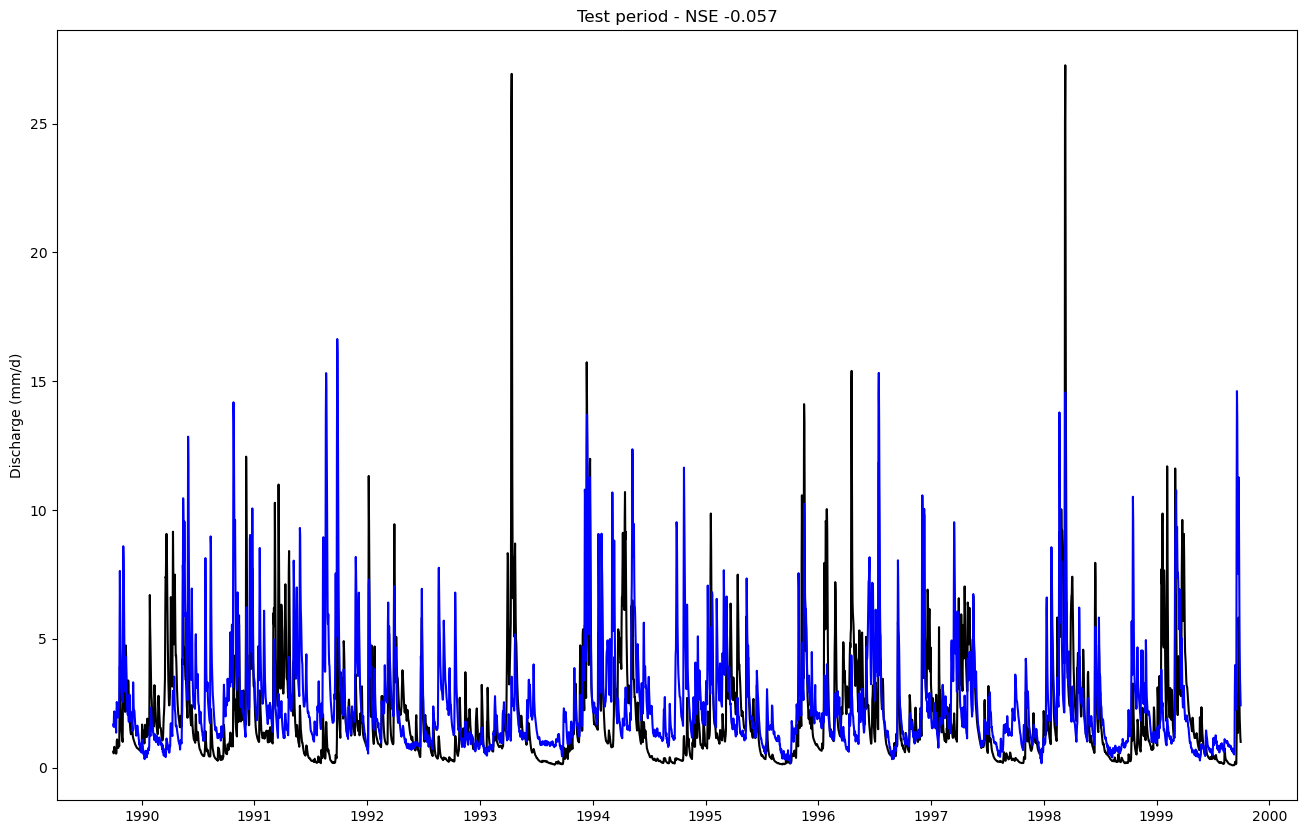

In [29]:
# extract observations and simulations
qobs = results['01022500']['1D']['xr']['QObs(mm/d)_obs']
qsim = results['01022500']['1D']['xr']['QObs(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs, c='k',label='obs')
ax.plot(qsim['date'], qsim, c='b',label='sim')
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01022500']['1D']['NSE']:.3f}")

Next, we are going to compute all metrics that are implemented in the NeuralHydrology package. You will find additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

In [30]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

NSE: -0.057
MSE: 5.204
RMSE: 2.281
KGE: 0.404
Alpha-NSE: 0.924
Beta-KGE: 1.223
Beta-NSE: 0.202
Pearson-r: 0.453
FHV: -0.720
FMS: -28.327
FLV: -22.861
Peak-Timing: 0.217
Peak-MAPE: 57.126


## Create placeholder data file

In [5]:
import xarray as xr
import datetime
import numpy as np
import pandas as pd

In [6]:
start_date = datetime.datetime(year=1980,month=10,day=1)
stop_date = datetime.datetime(year=2008,month=9,day=30)
date_idx = pd.date_range(start=start_date, end = stop_date)
t_n = len(date_idx)

### Create fake .nc DataArray file

In [8]:
data = np.random.rand(t_n)

In [32]:
da = xr.DataArray(data=data,
            dims=["date"],
            coords=[date_idx],
            attrs=dict(
                description="A single variable.",
                units="None",
            ))

In [34]:
da.to_netcdf(synth_data_dir+'01022500.nc')

### Create fake .nc Dataset file

In [7]:
data = np.random.rand(t_n,2)

In [8]:
ds = xr.Dataset({'var_0':('date',data[:,0]),'var_1':('date',data[:,1])},
           coords={'date':date_idx},
           attrs=dict(
                description="TWO variables.",
                units="Still none",
            ))

In [29]:
example_dict = {'01022500': ds}
pickle.dump(example_dict, open(synth_data_dir+'trial_ds.pkl', 'wb'))

In [10]:
df_from_ds = ds.to_dataframe()

In [13]:
example_dict = {'01022500': df_from_ds}
pickle.dump(example_dict, open(synth_data_dir+'trial_df.pkl', 'wb'))

### Create fake pandas dataframe
Path to a pickle file (or list of paths for multiple files), containing a dictionary with each key corresponding to one basin id and the value is a date-time indexed pandas DataFrame.

In [10]:
data = np.random.rand(t_n,5)

In [11]:
df = pd.DataFrame(data, index= date_idx)
df = df.add_prefix('var_',axis=1) # gives a string name to each var
# df['date'] = df.index

In [12]:
df.index.name = 'date'

In [13]:
example_dict = {'01022500': df}
pickle.dump(example_dict, open(synth_data_dir+'trial.pkl', 'wb'))

In [4]:
pck_read = pickle.load(open(synth_data_dir+'trial.pkl', 'rb'))

In [6]:
pck_read['01022500'].groupby('date')

In [16]:
df[df.index.duplicated(keep=False)]